In [43]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(15,15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), cmap="gray", vmin=0, vmax=255)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [45]:
def _plot(images, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    #if title:
    #    plt.title(title)
    image = make_grid(images)
    show(images)
    #plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

In [46]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [55]:
# context initialization
with initialize(config_path="../training/conf/"):
    cfg = compose(config_name="config", overrides=["+experiment=barlow_twins_paragraphs"])

seed: 4711
tune: false
train: true
test: true
logging: INFO
work_dir: ${hydra:runtime.cwd}
debug: false
print_config: false
ignore_warnings: true
summary:
- - 1
  - 1
  - 576
  - 640
callbacks:
  lightning:
    model_checkpoint:
      _target_: pytorch_lightning.callbacks.ModelCheckpoint
      monitor: val/loss
      save_top_k: 1
      save_last: true
      mode: min
      verbose: false
      dirpath: checkpoints/
      filename: '{epoch:02d}'
    learning_rate_monitor:
      _target_: pytorch_lightning.callbacks.LearningRateMonitor
      logging_interval: step
      log_momentum: false
  wandb:
    watch_model:
      _target_: callbacks.wandb_callbacks.WatchModel
      log: all
      log_freq: 100
    upload_code_as_artifact:
      _target_: callbacks.wandb_callbacks.UploadConfigAsArtifact
    upload_ckpts_as_artifact:
      _target_: callbacks.wandb_callbacks.UploadCheckpointsAsArtifact
      ckpt_dir: checkpoints/
      upload_best_only: true
  stochastic_weight_averaging:
    _ta

In [57]:
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()
print(datamodule)

2021-10-24 14:12:56.488 | INFO     | text_recognizer.data.iam_paragraphs:setup:92 - Loading IAM paragraph regions and lines for None...
2021-10-24 14:13:16.883 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transform/barlow_paragraphs.yaml
2021-10-24 14:13:20.157 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transform/barlow_paragraphs.yaml
2021-10-24 14:13:20.180 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:67 - IAM Synthetic dataset steup for stage None...
2021-10-24 14:13:32.567 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transform/barlow_paragraphs.yaml


IAM Original and Synthetic Paragraphs Dataset
Num classes: 58
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 20036, 131, 231
Train Batch x stats: (torch.Size([16, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0128), tensor(0.0619), tensor(1.))
Train Batch y stats: (torch.Size([16, 682]), torch.int64, tensor(1), tensor(57))
Test Batch x stats: (torch.Size([16, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0381), tensor(0.1004), tensor(1.))
Test Batch y stats: (torch.Size([16, 682]), torch.int64, tensor(1), tensor(57))



<Figure size 864x864 with 0 Axes>

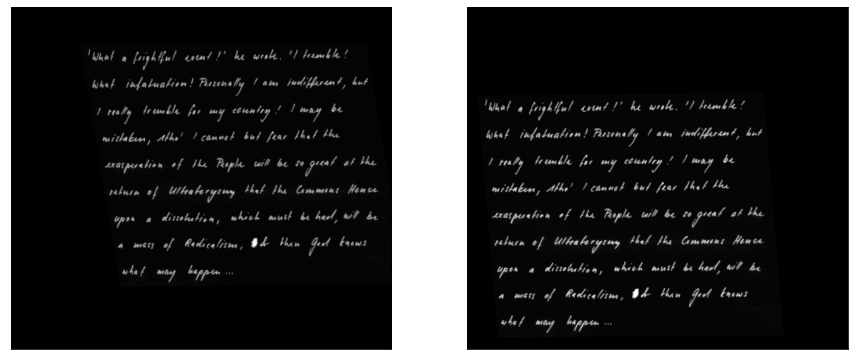

In [85]:
# Training
dataset = datamodule.data_train
for _ in range(1):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(list(x), vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))